<a href="https://colab.research.google.com/github/ffaisal93/codes/blob/master/credit_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import spacy
import pickle
import numpy as np
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.externals import joblib

############ Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
# Import Seaborn
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# The shareable data link
train_link = 'https://drive.google.com/file/d/1Cvmg9flVaJXPLOWoehPtbpBY2lWjPYyK/view?usp=sharing'
test_link = 'https://drive.google.com/file/d/1EAj4ZQtI5aY-klEZ82my6bIOMMbDtRci/view?usp=sharing'

In [6]:
# function to upload the training and testing file from the drive
def link_open(link,filename):
  # getting the file key portion. 
  # eg. 1OA-r-ZOAUsYdK1kgcWP50hSr8BDqj6Fn from https://drive.google.com/file/d/1OA-r-ZOAUsYdK1kgcWP50hSr8BDqj6Fn/view?usp=sharing
  id = link.split('/')
  print (id[5]) 
  downloaded = drive.CreateFile({'id':id[5]}) 
  downloaded.GetContentFile(filename+'.csv')  
  df3 = pd.read_csv(filename+'.csv')
  # Dataset is now stored in a Pandas Dataframe
  return df3

In [10]:
train_df = link_open(train_link, '1600106342_882043_train')
test_df = link_open(test_link, '1600106342_8864183_test')

1Cvmg9flVaJXPLOWoehPtbpBY2lWjPYyK
1EAj4ZQtI5aY-klEZ82my6bIOMMbDtRci


In [11]:
# path = '../hw2/data'
# TRAINFILE = '1600106342_882043_train.csv'
# TESTFILE = '1600106342_8864183_test.csv'

In [12]:
# train_df = pd.read_csv(os.path.join(path, TRAINFILE), sep=",", header=0)
# test_df = pd.read_csv(os.path.join(path, TESTFILE), sep=",", header=0)

    id - unique identifier
    F1 - Continuous value describing number of years since last degree was completed
    F2 - Continuous value indicating hours worked per week
    F3 - Categorical Value
    F4 - Categorical Value indicating type of occupation
    F5 - continuous value denoting gains
    F6 - continuous value denoting loss
    F7 - Categorical value denoting marital status
    F8 - Categorical value denoting type of employment (e.g., Self)
    F9 - Categorical Value denoting education type
    F10 - Categorical Value denoting different race
    F11 - Categorical - Female/Male
    credit - 0: Bad, 1: Good

In [13]:
train_df.head(5)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,credit
0,0,13,40,1,1,2174,0,4,7,9,White,Male,0
1,1,13,13,0,4,0,0,2,6,9,White,Male,0
2,2,9,40,1,6,0,0,0,4,11,White,Male,0
3,3,7,40,0,6,0,0,2,4,1,Black,Male,0
4,4,13,40,5,10,0,0,2,4,9,Black,Female,0


In [14]:
test_df.head(5)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
0,0,7,40,3,7,0,0,4,4,1,Black,Male
1,1,12,40,0,11,0,0,2,2,7,White,Male
2,2,10,40,0,7,7688,0,2,4,15,Black,Male
3,3,10,30,3,0,0,0,4,0,15,White,Female
4,4,6,30,1,8,0,0,4,4,0,White,Male


In [15]:
train_df.dtypes

id         int64
F1         int64
F2         int64
F3         int64
F4         int64
F5         int64
F6         int64
F7         int64
F8         int64
F9         int64
F10       object
F11       object
credit     int64
dtype: object

In [16]:
cat_columns = train_df.select_dtypes(['object']).columns
for col in cat_columns:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')
train_df[cat_columns] = train_df[cat_columns].apply(lambda x: x.cat.codes)
test_df[cat_columns] = test_df[cat_columns].apply(lambda x: x.cat.codes)

In [17]:
train_df.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,credit
0,0,13,40,1,1,2174,0,4,7,9,4,1,0
1,1,13,13,0,4,0,0,2,6,9,4,1,0
2,2,9,40,1,6,0,0,0,4,11,4,1,0
3,3,7,40,0,6,0,0,2,4,1,2,1,0
4,4,13,40,5,10,0,0,2,4,9,2,0,0


In [18]:
cols = ['F3','F4','F7','F8','F9','F10','F11']

for col in cols:
    print(col, train_df[col].nunique())

F3 6
F4 15
F7 7
F8 9
F9 16
F10 5
F11 2


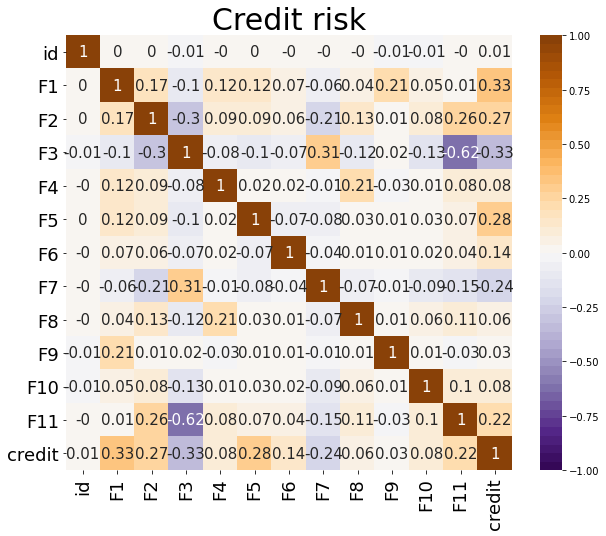

In [19]:
def confusion_matrix_plot(data, title = "Name", height = 8, width = 10):
    # Get the confusion matrix
    conf_mat = round(data.corr(method ="spearman"), 2)
    # Create the heatmap
    plt.figure(figsize = (width, height))
    ax = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 15}, cmap = sns.color_palette("PuOr_r", 50), 
                     vmin = -1, vmax = 1)
    # Customize the style of the heatmap
    # Set the title, it's font size and position
    ax.axes.set_title(title, fontsize = 30)
    ax.title.set_position([.5, 1.03])
    ax.set_xticklabels(labels = conf_mat.index, fontsize = 18, rotation =90)
    ax.set_yticklabels(labels = conf_mat.index, fontsize = 18, rotation = 0)
    # Show the plot
    plt.show()
    
# Call the confusion matrix function
confusion_matrix_plot(train_df, title = "Credit risk")

    positively correlated:
            .F5, F1, F2, F11
    negatively correlated:
            .F3, F7
    Little correlation:
            .F9, F8, F4
            

In [28]:
def drop_columns(cols, df):
    for col in cols:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    return df

cols = ['id','F4', 'F8', 'F9']
train_df = drop_columns(cols, train_df)
test_df = drop_columns(cols, test_df)

In [29]:
train_df.head()

,F1,F2,F3,F5,F6,F7,F10,F11,credit
0,13,40,1,2174,0,4,4,1,0
1,13,13,0,0,0,2,4,1,0
2,9,40,1,0,0,0,4,1,0
3,7,40,0,0,0,2,2,1,0
4,13,40,5,0,0,2,2,0,0


In [30]:
def cat_to_onehot(cols, df):
    for col in cols:
        dummies = pd.get_dummies(df[col],prefix=col)
        df = pd.concat([df, dummies],axis=1)
        df.drop(col, axis=1, inplace=True)
    return df

cols = ['F3','F7','F10','F11']
train_df_f = cat_to_onehot(cols, train_df)
test_df_f = cat_to_onehot(cols, test_df)

In [31]:
train_df_f.shape

(32561, 25)

In [32]:
train_label = train_df_f['credit'].values
train_sc = train_df_f.drop('credit',axis=1)
test_sc = test_df_f
scaler = MinMaxScaler()

train_sc[train_sc.columns] = scaler.fit_transform(train_sc)
test_sc[test_sc.columns] = scaler.fit_transform(test_sc)

In [33]:
# applying standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_sc)

train_sc[train_sc.columns] = scaler.transform(train_sc)  
test_sc[test_sc.columns] = scaler.transform(test_sc)

In [34]:
train_sc.head()

,F1,F2,F5,F6,F3_0,F3_1,F3_2,F3_3,F3_4,F3_5,F7_0,F7_1,F7_2,F7_3,F7_4,F7_5,F7_6,F10_0,F10_1,F10_2,F10_3,F10_4,F11_0,F11_1
0,1.134739,-0.035429,0.148453,-0.21666,-0.825333,1.708991,-0.17625,-0.429346,-0.344032,-0.224927,-0.397508,-0.026587,-0.922841,-0.114037,1.431058,-0.180285,-0.177358,-0.098201,-0.181552,-0.325768,-0.091612,0.413020,-0.703071,0.703071
1,1.134739,-2.222153,-0.145920,-0.21666,1.211632,-0.585141,-0.17625,-0.429346,-0.344032,-0.224927,-0.397508,-0.026587,1.083611,-0.114037,-0.698784,-0.180285,-0.177358,-0.098201,-0.181552,-0.325768,-0.091612,0.413020,-0.703071,0.703071
2,-0.420060,-0.035429,-0.145920,-0.21666,-0.825333,1.708991,-0.17625,-0.429346,-0.344032,-0.224927,2.515672,-0.026587,-0.922841,-0.114037,-0.698784,-0.180285,-0.177358,-0.098201,-0.181552,-0.325768,-0.091612,0.413020,-0.703071,0.703071
3,-1.197459,-0.035429,-0.145920,-0.21666,1.211632,-0.585141,-0.17625,-0.429346,-0.344032,-0.224927,-0.397508,-0.026587,1.083611,-0.114037,-0.698784,-0.180285,-0.177358,-0.098201,-0.181552,3.069667,-0.091612,-2.421192,-0.703071,0.703071
4,1.134739,-0.035429,-0.145920,-0.21666,-0.825333,-0.585141,-0.17625,-0.429346,-0.344032,4.445891,-0.397508,-0.026587,1.083611,-0.114037,-0.698784,-0.180285,-0.177358,-0.098201,-0.181552,3.069667,-0.091612,-2.421192,1.422331,-1.422331


In [35]:
def evaluation(classifier, y_test, y_pred, target_names, title):  
    print(title)
    print('f1 score: ',f1_score(y_test,y_pred))
    print(classification_report(y_test,y_pred, target_names=target_names))
    return f1_score(y_test,y_pred)

In [ ]:
from sklearn.metrics import fbeta_score, make_scorer

def grid_search_cv(classifier, param_grid, n_fold,X,y):
    # instantiate the grid
    grid = GridSearchCV(classifier, param_grid, cv=n_fold, scoring='f1_micro',verbose = 1)
    # fit the grid with data
    grid.fit(X, y)
    print(grid.cv_results_.keys())
    # view the complete results (list of named tuples)
    grid_result = pd.DataFrame(grid.cv_results_)
    print("best estimator: ",grid.best_estimator_)
    print("best score:", grid.best_score_)
    return grid_result, grid.best_estimator_

In [ ]:
X = train_sc
y = train_label

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  

# defining a python dictionary to save the best estimators
estimators = {}
knn = KNeighborsClassifier()  
# define the parameter values that should be searched
# k_range = range(1, 31) [neighbour number list]
k_range = [10,50,100,200,300,350]
print(k_range)
# create a parameter grid: map the parameter names to the values that should be searched
# simply a python dictionary
# key: parameter name
# value: list of values that should be searched for that parameter
# single key-value pair for param_grid
param_grid = dict(n_neighbors=k_range)
print(param_grid)
#sending classifier, parameters, training features and labels to the grid_search function
grid_result,best_est  = grid_search_cv(knn, param_grid, 5, X,y)
#save best estimator of knn to estimators dictionary
estimators['knn'] = best_est

[10, 50, 100, 200, 300, 350]
{'n_neighbors': [10, 50, 100, 200, 300, 350]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.5min finished


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
best estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
best score: 0.8355088867813418


In [ ]:
##using svm
classifier_svm = SVC()
param_grid = {'C': [.1, 1, 100, 1000],
                  'gamma': [0.001, 0.01, .1],'kernel': ['rbf', 'sigmoid']}
print(param_grid)
grid_result, best_est  = grid_search_cv(classifier_svm, param_grid, 5, X,y)
estimators['svm'] = best_est

{'C': [0.1, 1, 100, 1000], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf', 'sigmoid']}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 101.3min finished


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
best estimator:  SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
best score: 0.8457052866484004


In [ ]:
#import PipeLine, SelectKBest transformer, and RandomForest estimator classes
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier

#initialize randomforest
clf = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True)

#Create the parameter grid, entering the values to use for each parameter selected in the RandomForest estimator
param_grid = { 
    'n_estimators': [20,50,100],
    'max_features': ['auto', 'sqrt', 'log2']
}
print(param_grid)
grid_result, best_est  = grid_search_cv(clf, param_grid, 5, X,y)
estimators['clf'] = best_est

{'n_estimators': [20, 50, 100], 'max_features': ['auto', 'sqrt', 'log2']}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.4min finished


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)
best score: 0.8052876198085779


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
scl = ('scl', StandardScaler())
rdm = ('rdm', RFECV(estimator=DecisionTreeClassifier(random_state=42), scoring='f1_micro'))
clf = ('clf', DecisionTreeClassifier(random_state=42))

param_grid = [{'rdm__step': [0.02],
               'clf__criterion': ['gini', 'entropy']}]


pipe = Pipeline([scl, rdm, clf])
print(param_grid)
grid_result, best_est  = grid_search_cv(pipe, param_grid, 5, X_sm,y_sm.ravel())
estimators['ds'] = best_est

[{'rdm__step': [0.02], 'clf__criterion': ['gini', 'entropy']}]
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.4min finished


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__criterion', 'param_rdm__step', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
best estimator:  Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rdm',
                 RFECV(cv=None,
                       estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impur

In [ ]:
import pickle

g_path = '/content/drive/My Drive/Colab Notebooks/data/'
with open(g_path+'estimators.pickle', 'wb') as handle:
          pickle.dump(estimators, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
max_f1 =0
best_est = 0
est_name = 0
# Split the the whole data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, random_state=1, stratify=y)
###iterate over estimator dictionary:[name(eg. 'knn','svm'), desc(eg. estimator description)]
for name, desc in estimators.items():
    estimators[name].fit(X_train,y_train)
    y_pred = estimators[name].predict(X_test)
    f1 = evaluation(estimators[name], y_test, y_pred,['-1','1'], 'Classification report ['+ name+'] :')
    if f1>max_f1:
      max_f1=f1
      best_est = estimators[name]
      est_name = name

In [ ]:
###now fit on whole train data 
best_est.fit(train_sc,train_label)
###predict on the given test data file 
y_pred = best_est.predict(test_sc)
###save the predicted results in text files. These are the files to upload in submission
with open(os.path.join(path,est_name+'.txt'), 'wb') as fout:  # Note 'wb' instead of 'w'
    np.savetxt(fout, y_pred, fmt='%d')
    fout.seek(NEWLINE_SIZE_IN_BYTES, 2)
    fout.truncate()